In [6]:
# Install necessary libraries
!pip install tensorflow numpy matplotlib scikit-learn


In [7]:
# Install the Kaggle package
!pip install -q kaggle


In [8]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"priyankatodkar31","key":"1f1fcd58a3a7104304811733836288c7"}'}

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [10]:
!kaggle datasets download -d gti-upm/leapgestrecog


Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.13G/2.13G [01:16<00:00, 32.9MB/s]
100% 2.13G/2.13G [01:16<00:00, 29.8MB/s]


In [11]:
!unzip leapgestrecog.zip -d leapGestRecog


Streaming output truncated to the last 5000 lines.
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapGestRecog/leapgestrecog/leapGest

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [13]:
base_dir = 'leapGestRecog/leapGestRecog'


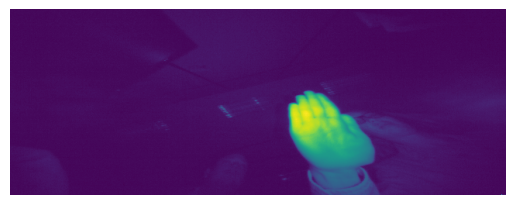

In [14]:
img = plt.imread(os.path.join(base_dir, '00/01_palm/frame_00_01_0001.png'))
plt.imshow(img)
plt.axis('off')
plt.show()


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% of data used for validation
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # Adjust output size based on number of gestures
])


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/20
108/500 [=====>........................] - ETA: 10:44 - loss: 0.0253 - accuracy: 0.9887

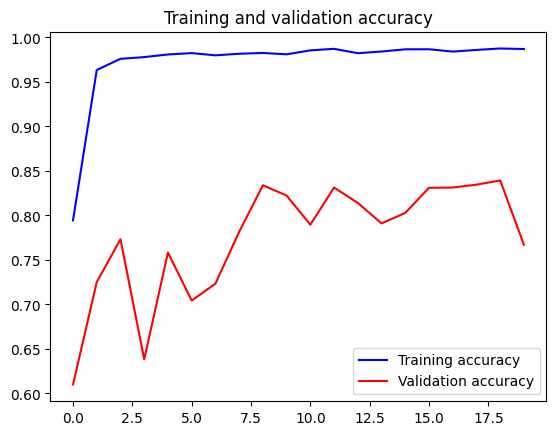

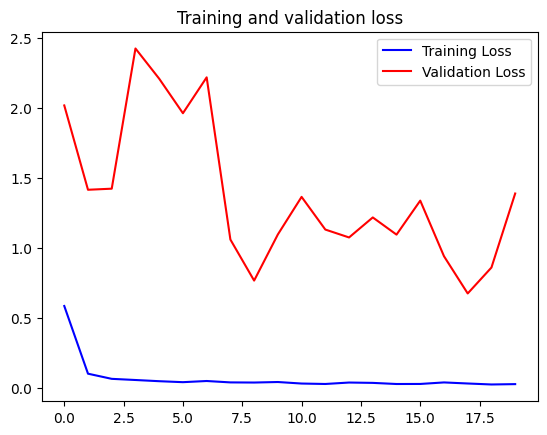

125/125 [==============================] - 81s 649ms/step - loss: 1.2162 - accuracy: 0.8213
Test accuracy: 0.8212500214576721


In [20]:
# Plot accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluate on test data
loss, accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {accuracy}')


125/125 [==============================] - 80s 638ms/step
              precision    recall  f1-score   support

          00       0.09      0.10      0.09       400
          01       0.11      0.11      0.11       400
          02       0.11      0.10      0.10       400
          03       0.12      0.13      0.12       400
          04       0.05      0.03      0.03       400
          05       0.08      0.08      0.08       400
          06       0.12      0.20      0.15       400
          07       0.09      0.09      0.09       400
          08       0.10      0.05      0.07       400
          09       0.10      0.12      0.11       400

    accuracy                           0.10      4000
   macro avg       0.10      0.10      0.10      4000
weighted avg       0.10      0.10      0.10      4000



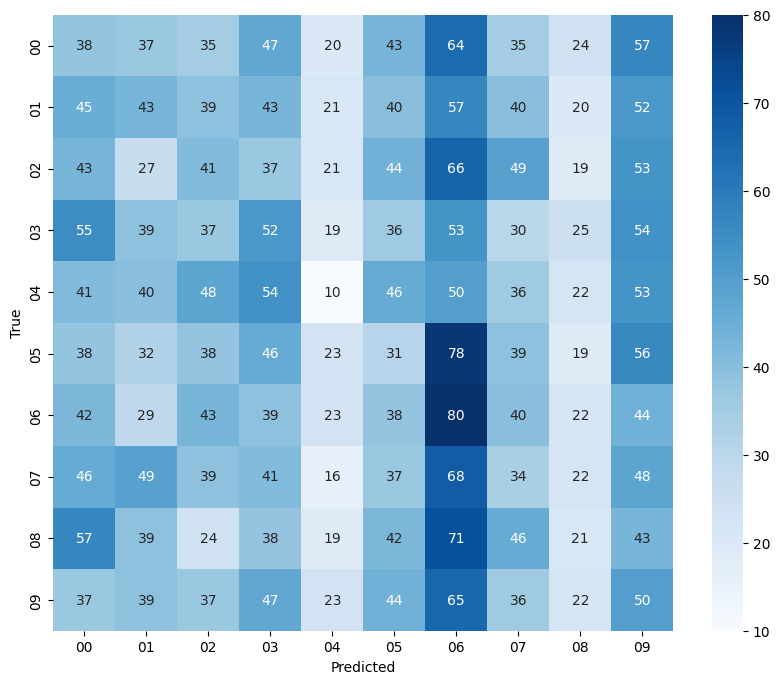

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Print classification report
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))

# Plot confusion matrix
cm = confusion_matrix(true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [23]:
model.save('hand_gesture_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
